## Задание

### Часть 1 (5 балла)
1. Выберите одну любую из задач, рассмотренных на [лекции](https://colab.research.google.com/drive/1B7Np_7y002NLiuNkriq6a6MchQL4Fw7p?usp=sharing) (локализация, сегментация, перенос стиля, генерация).

2. Подберите на kaggle датасет, подходящий для решения этой задачи.
  - Вариант 1: если данные обладают необходимой разметкой, то повторите пайплайн из блокнота с примером на своих данных.
  - Вариант 2: если данные не обладают необходимой разметкой, то используйте модель, которую дообучали в примере, но без дообучения.
3. Оцените и прокомментируйте результат.

### Часть 2 (8 баллов)
1. Выберите еще одну из рассмотренных в лекции задач (не совпадающую с первой).
2. Если ваши данные обладают разметкой, необходимой для новой задачи, продолжите работу с ними. Если нет, найдите другой датасет, в котором она будет. Можно взять какой-нибудь стандартный в PyTorch, но такой, который не встречался ни в одном из примеров с лекции. В этом задании обязательно нужно найти датасет с разметкой.
3. Повторите пайплайн из примера.
4. Постарайтесь улучшить качество результата (если классификация - точность выше 90%, во всех остальных - максимально понизить лосс). Это можно сделать за счет настройки гиперпараметров. Можно (опционально и в зависимости от задачи) также поменять гиперпараметры в слоях нейронных сетей и/или порядок слоев и/или их количество.

В заданиях, где перечислены два варианта выполнения, нужно выбрать только один. Выполнение обоих дополнительных баллов не дает.



# Часть 1 - перенос стиля

Выберем датасет на kaggle с фотографиями стилей и забавными Content Image и скачаем его

In [ ]:
!pip install torch torchvision

Иммпортируем нужные библиотеки и скопируем датасет в среду выполнения

In [ ]:
import kagglehub
import shutil
path = kagglehub.dataset_download("soumikrakshit/images-for-style-transfer")
source_dir = path
destination_dir = "/content/images-for-style-transfer"
shutil.copytree(source_dir, destination_dir)

100%|██████████| 131M/131M [00:08<00:00, 16.7MB/s]

Extracting files...


'/content/images-for-style-transfer'

Загрузим VGG19

In [ ]:
import torch
from torchvision import models

vgg = models.vgg19(pretrained=True)
vgg = vgg.features
for parameters in vgg.parameters():
  parameters.requires_grad_(False)
dev = torch.device("cuda" if torch.cuda.is_available else "cpu")
vgg.to(dev)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

Предобработаем изображения

In [ ]:
from PIL import Image
from torchvision import transforms as T

def preprocess(img_path, max_size=500):
  image = Image.open(img_path).convert("RGB")
  if max(image.size) > max_size:
    size = max_size
  else:
    size = max(image.size)

  img_transforms = T.Compose([
      T.Resize(size),
      T.ToTensor(),
      T.Normalize(mean=[0.485, 0.456, 0.406],
                  std=[0.229, 0.224, 0.225])
  ])
  image = img_transforms(image)
  image = image.unsqueeze(0) # (3, 224, 224) -> (1, 3, 224, 224)

  return image

content_preprocess = preprocess("/content/images-for-style-transfer/Data/TestCases/22714.jpg")
style_preprocess = preprocess("/content/images-for-style-transfer/Data/Artworks/324310.jpg")

content_preprocess = content_preprocess.to(dev)
style_preprocess = style_preprocess.to(dev)

print(f"Content shape {content_preprocess.shape}")
print(f"Style shape {style_preprocess.shape}")

Content shape torch.Size([1, 3, 500, 666])
Style shape torch.Size([1, 3, 500, 800])


Преобразуем вектор в картинку

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def deprocess(tensor):
  image = tensor.to("cpu").clone()
  image = image.numpy()
  image = image.squeeze(0) # (1, 3, 224, 224) -> (3, 224, 224)
  image = image.transpose(1, 2, 0) # (3, 224, 224) -> (224, 224, 3)
  image = image * np.array([0.485, 0.456, 0.406]) + np.array([0.229, 0.224, 0.225])
  image = image.clip(0,1)

  return image

content_deproc = deprocess(content_preprocess)
style_deproc = deprocess(style_preprocess)

print(f"Deprocess content: {content_deproc.shape}")
print(f"Deprocess style: {style_deproc.shape}")

Deprocess content: (500, 666, 3)
Deprocess style: (500, 800, 3)


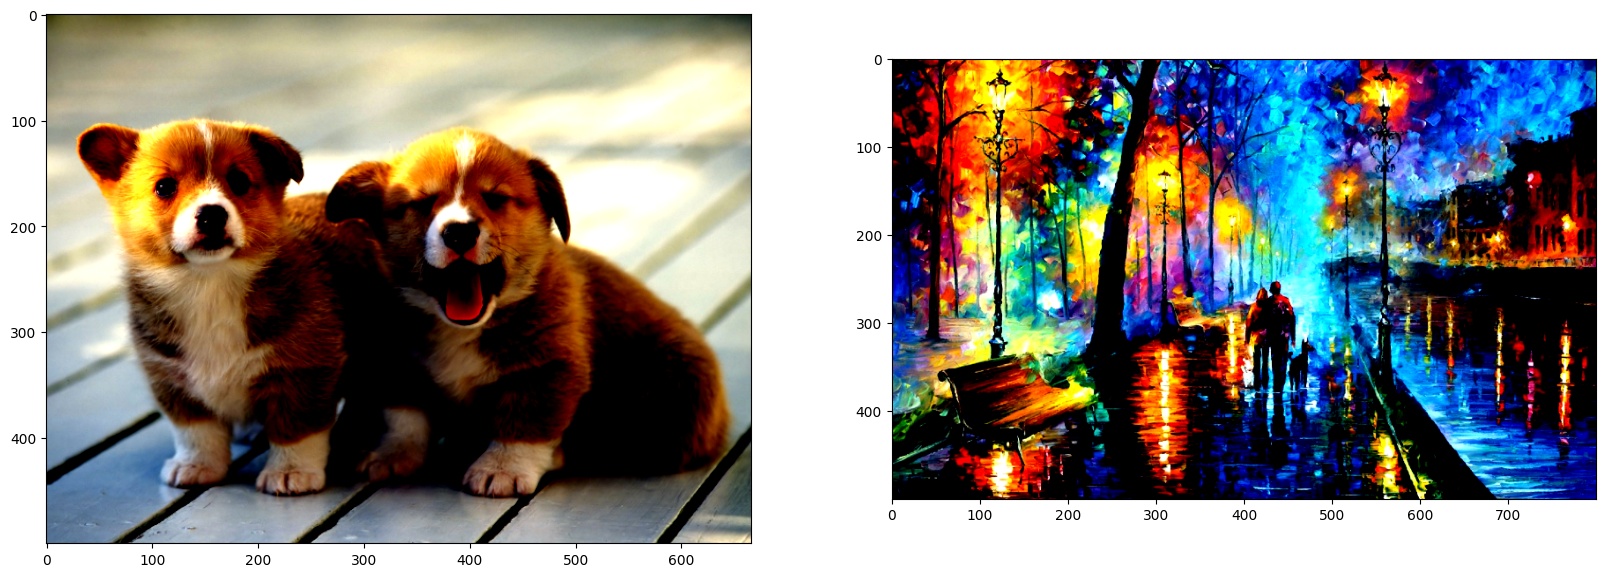

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,10))
ax1.imshow(content_deproc)
ax2.imshow(style_deproc);

Извлечем признаки из картинки и стиля, построим матрицу Грама

In [ ]:
def get_features(image, model):
  layers = {
      "0": "conv1_1",  # see representaion.png
      "5": "conv2_1",
      "10": "conv3_1",
      "19": "conv4_1",
      "21": "conv4_2", #content_feature
      "28": "conv5_1"
  }

  x = image
  Features = {}
  for name, layer in model._modules.items():
    x = layer(x)
    if name in layers:
      Features[layers[name]] = x

  return Features

content_features = get_features(content_preprocess, vgg)
style_features = get_features(style_preprocess, vgg)

def gram_matrix(tensor):
  b, c, h, w = tensor.size()
  tensor = tensor.view(c, h*w)
  gram = torch.mm(tensor, tensor.t())
  return gram

style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

Создадим функцию потерь для картинки и стиля

In [ ]:
def content_loss(target_conv4_2, content_conv4_2):
  loss = torch.mean((target_conv4_2-content_conv4_2)**2)
  return loss

style_weights = {
    "conv1_1": 1.0,
    "conv2_1": 0.75,
    "conv3_1": 0.75,
    "conv4_1": 0.75,
    "conv5_1": 0.75
}

def style_loss(style_weights, target_fs, style_grams):
  loss = 0
  for layer in style_weights:
    target_feature = target_fs[layer]
    target_gram = gram_matrix(target_feature)
    style_gram = style_grams[layer]
    b, c, h, w = target_feature.shape
    layer_loss = style_weights[layer]*torch.mean((target_gram-style_gram)**2)
    loss += layer_loss/(c*h*w)

  return loss

target = content_preprocess.clone().requires_grad_(True).to(dev)
target_f = get_features(target,vgg)
print(f"Content loss: {content_loss(target_f['conv4_2'], content_features['conv4_2'])}")
print(f"Style loss: {style_loss(style_weights, target_f,style_grams)}")

Content loss: 0.0
Style loss: 2196.497314453125


Обучим модель

In [ ]:
from torch import optim

optimizer = optim.Adam([target],lr=0.003)

alpha = 1.0
beta = 1e5
epochs = 4000
show_every = 500

def total_loss(c_loss, s_loss, alpha, beta):
  loss = alpha*c_loss + beta*s_loss
  return loss

results = []

for i in range(epochs):
  target_f = get_features(target,vgg)
  c_loss = content_loss(target_f["conv4_2"], content_features["conv4_2"])
  s_loss = style_loss(style_weights, target_f, style_grams)
  t_loss = total_loss(c_loss,s_loss, alpha, beta)

  optimizer.zero_grad()
  t_loss.backward()
  optimizer.step()

  if i % show_every == 0:
    print(f"Total loss at Epoch {i}: {t_loss}")
    results.append(deprocess(target.detach()))

Total loss at Epoch 0: 219649728.0
Total loss at Epoch 500: 22317586.0
Total loss at Epoch 1000: 3442522.5
Total loss at Epoch 1500: 1234160.125
Total loss at Epoch 2000: 782609.3125
Total loss at Epoch 2500: 546556.625
Total loss at Epoch 3000: 402246.75
Total loss at Epoch 3500: 307604.03125


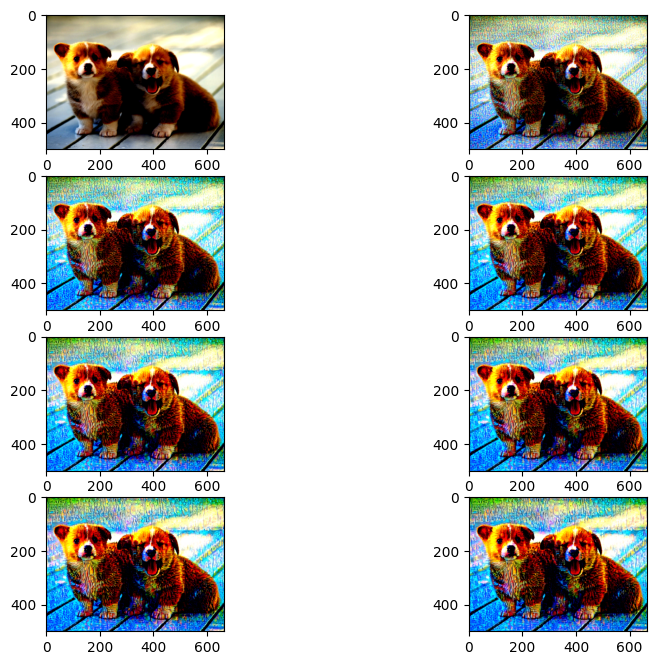

In [ ]:
plt.figure(figsize=(10,8))
for i,_ in enumerate(results):
  plt.subplot(4,2, i+1)
  plt.imshow(results[i])
plt.show()

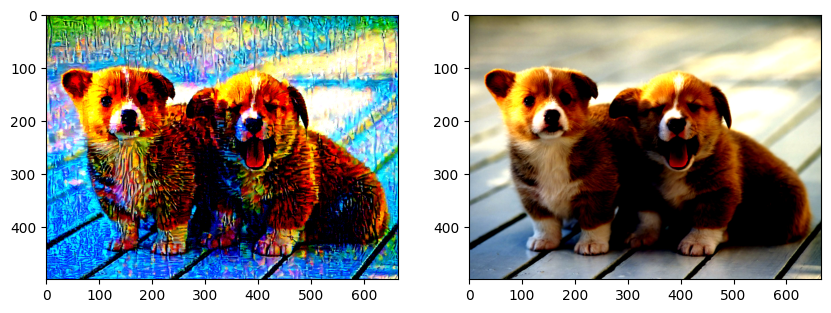

In [ ]:
target_copy = deprocess(target.detach())
content_copy = deprocess(content_preprocess)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.imshow(target_copy)
ax2.imshow(content_copy);

Вывод:
В ходе выполнения лабораторной работы по переносу стиля удалось реализовать алгоритм переноса стиля на основе сверточных нейронных сетей. Основная цель заключалась в создании изображения, сочетающего контент одного изображения и стиль другого.

Loss получился высоким - около 300.000, в целом это не самый лучший результат. Возможно можно дело в качестве исходных изображений, также можно попробовать увеличить Epochs.


# Часть 2


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [ ]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:06<00:00, 28.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Подбор гиперпараметров

In [ ]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:12<00:00, 13.2MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 256 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

NameError: name 'StepLR' is not defined

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)

In [ ]:
def train(model, trainloader, criterion, optimizer, epoch):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100:.4f}')
            running_loss = 0.0


In [ ]:
num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    scheduler.step()

    # Проверка на валидационном наборе
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(trainloader)}, Accuracy: {100 * correct / total}%')

Epoch 1/50, Loss: 1.4368084398529413, Accuracy: 60.99%
Epoch 2/50, Loss: 1.0977340747633249, Accuracy: 66.13%
Epoch 3/50, Loss: 0.968994210900553, Accuracy: 68.53%
Epoch 4/50, Loss: 0.8913715266815537, Accuracy: 71.09%
Epoch 5/50, Loss: 0.8320238792606632, Accuracy: 71.67%
Epoch 6/50, Loss: 0.7606390864038102, Accuracy: 74.36%
Epoch 7/50, Loss: 0.7298761705303436, Accuracy: 75.28%
Epoch 8/50, Loss: 0.7057820605042645, Accuracy: 75.81%
Epoch 9/50, Loss: 0.6826062516102096, Accuracy: 75.16%
Epoch 10/50, Loss: 0.6575998187141345, Accuracy: 76.44%
Epoch 11/50, Loss: 0.6219988892145474, Accuracy: 77.62%
Epoch 12/50, Loss: 0.6061488928087532, Accuracy: 77.83%
Epoch 13/50, Loss: 0.589473325959252, Accuracy: 77.59%
Epoch 14/50, Loss: 0.5756023555536709, Accuracy: 78.83%
Epoch 15/50, Loss: 0.563187940193869, Accuracy: 78.84%
Epoch 16/50, Loss: 0.5415122983477, Accuracy: 79.21%
Epoch 17/50, Loss: 0.5330398476604, Accuracy: 79.4%
Epoch 18/50, Loss: 0.5186182324348203, Accuracy: 79.71%
Epoch 19/50

KeyboardInterrupt: 

In [ ]:
def test(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')
    return accuracy

In [ ]:
num_epochs = 30
best_accuracy = 0
for epoch in range(num_epochs):
    train(model, trainloader, criterion, optimizer, epoch)
    accuracy = test(model, testloader)
    scheduler.step()

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), 'best_model.pth')
        print(f'Model saved with accuracy: {best_accuracy:.2f}%')

print('Training completed.')
print(f'Best accuracy: {best_accuracy:.2f}%')

Epoch 1, Batch 100, Loss: 2.1185
Epoch 1, Batch 200, Loss: 1.6633
Epoch 1, Batch 300, Loss: 1.5773
Accuracy: 49.93%
Model saved with accuracy: 49.93%
Epoch 2, Batch 100, Loss: 1.4189
Epoch 2, Batch 200, Loss: 1.3386
Epoch 2, Batch 300, Loss: 1.2899
Accuracy: 57.84%
Model saved with accuracy: 57.84%
Epoch 3, Batch 100, Loss: 1.1967
Epoch 3, Batch 200, Loss: 1.1710
Epoch 3, Batch 300, Loss: 1.1264
Accuracy: 62.91%
Model saved with accuracy: 62.91%
Epoch 4, Batch 100, Loss: 1.0961
Epoch 4, Batch 200, Loss: 1.0627
Epoch 4, Batch 300, Loss: 1.0639
Accuracy: 64.36%
Model saved with accuracy: 64.36%
Epoch 5, Batch 100, Loss: 1.0257
Epoch 5, Batch 200, Loss: 1.0154
Epoch 5, Batch 300, Loss: 0.9927
Accuracy: 70.96%
Model saved with accuracy: 70.96%
Epoch 6, Batch 100, Loss: 0.9616
Epoch 6, Batch 200, Loss: 0.9466
Epoch 6, Batch 300, Loss: 0.9496
Accuracy: 70.64%
Epoch 7, Batch 100, Loss: 0.9060
Epoch 7, Batch 200, Loss: 0.8945
Epoch 7, Batch 300, Loss: 0.8975
Accuracy: 71.05%
Model saved with a

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 256 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)

def train(model, trainloader, criterion, optimizer, epoch):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100:.4f}')
            running_loss = 0.0

num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # scheduler.step()

    # Проверка на валидационном наборе
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(trainloader)}, Accuracy: {100 * correct / total}%')

Epoch 1/30, Loss: 1.5092608660383298, Accuracy: 54.8%
Epoch 2/30, Loss: 1.1566695058742142, Accuracy: 61.44%
Epoch 3/30, Loss: 1.031167687357539, Accuracy: 66.37%
Epoch 4/30, Loss: 0.9529381296823701, Accuracy: 67.95%
Epoch 5/30, Loss: 0.8955511116920529, Accuracy: 67.43%
Epoch 6/30, Loss: 0.850117510389489, Accuracy: 71.16%
Epoch 7/30, Loss: 0.8090920637330741, Accuracy: 72.12%
Epoch 8/30, Loss: 0.7742215735680612, Accuracy: 73.41%
Epoch 9/30, Loss: 0.7461550633620728, Accuracy: 73.23%
Epoch 10/30, Loss: 0.7181065416397037, Accuracy: 75.44%
Epoch 11/30, Loss: 0.6994694254892256, Accuracy: 74.68%
Epoch 12/30, Loss: 0.6825708174492087, Accuracy: 75.55%
Epoch 13/30, Loss: 0.6554423008123627, Accuracy: 75.35%
Epoch 14/30, Loss: 0.6449022139124858, Accuracy: 76.37%
Epoch 15/30, Loss: 0.6258382871937569, Accuracy: 77.78%
Epoch 16/30, Loss: 0.6081941711628224, Accuracy: 77.47%
Epoch 17/30, Loss: 0.597897916651138, Accuracy: 77.41%
Epoch 18/30, Loss: 0.5837054668789934, Accuracy: 77.86%
Epoch

In [ ]:
def test(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')
    return accuracy

num_epochs = 30
best_accuracy = 0
for epoch in range(num_epochs):
    train(model, trainloader, criterion, optimizer, epoch)
    accuracy = test(model, testloader)
    # scheduler.step()

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), 'best_model.pth')
        print(f'Model saved with accuracy: {best_accuracy:.2f}%')

print('Training completed.')
print(f'Best accuracy: {best_accuracy:.2f}%')

Epoch 1, Batch 100, Loss: 0.4554
Epoch 1, Batch 200, Loss: 0.4666
Epoch 1, Batch 300, Loss: 0.4628
Accuracy: 81.48%
Model saved with accuracy: 81.48%
Epoch 2, Batch 100, Loss: 0.4426
Epoch 2, Batch 200, Loss: 0.4621
Epoch 2, Batch 300, Loss: 0.4521
Accuracy: 81.60%
Model saved with accuracy: 81.60%
Epoch 3, Batch 100, Loss: 0.4485
Epoch 3, Batch 200, Loss: 0.4396
Epoch 3, Batch 300, Loss: 0.4506
Accuracy: 80.31%
Epoch 4, Batch 100, Loss: 0.4422
Epoch 4, Batch 200, Loss: 0.4249
Epoch 4, Batch 300, Loss: 0.4414
Accuracy: 81.71%
Model saved with accuracy: 81.71%
Epoch 5, Batch 100, Loss: 0.4386
Epoch 5, Batch 200, Loss: 0.4182
Epoch 5, Batch 300, Loss: 0.4458
Accuracy: 81.45%
Epoch 6, Batch 100, Loss: 0.4432
Epoch 6, Batch 200, Loss: 0.4214
Epoch 6, Batch 300, Loss: 0.4241
Accuracy: 81.96%
Model saved with accuracy: 81.96%
Epoch 7, Batch 100, Loss: 0.4147
Epoch 7, Batch 200, Loss: 0.4204
Epoch 7, Batch 300, Loss: 0.4145
Accuracy: 82.37%
Model saved with accuracy: 82.37%
Epoch 8, Batch 100

В ходе работы над улучшением точности модели, которая на текущий момент не превышает 90%, можно выделить несколько направлений для дальнейшего исследования. Возможно, стоит углубиться в оптимизацию гиперпараметров. Параметры нуждаются в тщательной настройке для достижения лучших результатов.
Стоит обратить внимание на более сложные методы аугментации данных, рассмотреть возможность перехода к более продвинутым архитектурам по типу DenseNet

## Куда сдавать?

По инструкции в гитхаб – https://shy-question-39d.notion.site/1150ea832e418032bfc3d3e827c380fb?pvs=74

- К этой работе тестов нет.
- Эту работу можно выполнить с кем-нибудь в паре или в гордом одиночестве.
- Пул-реквест нужно сделать в ветку `lab3`. Если вас двое, то можно 1 или 2 пул-реквеста, главное – отметьте как-нибудь, что выполняли в паре.

**Устная защита работ не требуется, но вам могут быть заданы вопросы прямо в вашем пул-реквесте!**